In [1]:
# Imports
import xml.etree.ElementTree as ET
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import umap

from collections import defaultdict
from sklearn.metrics import silhouette_score
import nltk
from nltk.stem import WordNetLemmatizer

## Extracting gds ids from pmids

In [2]:
# generating a list with pmids from the input file
with open("PMIDs_list.txt", "r") as f:
    pmids = [line.strip() for line in f if line.strip()]

# Removing duplicats
seen = set() # used later
unique_pmids = []

for pmid in pmids:
    if pmid not in seen:
        seen.add(pmid)
        unique_pmids.append(pmid)

In [3]:
# Creating elink request and requesting
ids_param = ",".join(unique_pmids)

url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi"
params = {
    "dbfrom": "pubmed",
    "db": "gds",
    "linkname": "pubmed_gds",
    "id": ids_param,
    "retmode": "xml"
}

response = requests.get(url, params=params)

In [4]:
print(response.status_code)
print(response.text)

200
<?xml version="1.0" encoding="UTF-8" ?>
<!DOCTYPE eLinkResult PUBLIC "-//NLM//DTD elink 20101123//EN" "https://eutils.ncbi.nlm.nih.gov/eutils/dtd/20101123/elink.dtd">
<eLinkResult>

  <LinkSet>
    <DbFrom>pubmed</DbFrom>
    <IdList>
      <Id>30530648</Id>
      <Id>31820734</Id>
      <Id>31018141</Id>
      <Id>38539015</Id>
      <Id>33763704</Id>
      <Id>32572264</Id>
      <Id>31002671</Id>
      <Id>33309739</Id>
      <Id>21057496</Id>
      <Id>27716510</Id>
      <Id>34059805</Id>
      <Id>34941412</Id>
      <Id>33879573</Id>
      <Id>35440059</Id>
      <Id>29462153</Id>
      <Id>29794063</Id>
      <Id>25939354</Id>
      <Id>30322904</Id>
      <Id>36879017</Id>
      <Id>35419551</Id>
      <Id>31501549</Id>
      <Id>23042784</Id>
      <Id>22219169</Id>
      <Id>20670891</Id>
      <Id>20385583</Id>
      <Id>19723310</Id>
      <Id>20602769</Id>
      <Id>26566685</Id>
      <Id>38030723</Id>
      <Id>30498128</Id>
      <Id>20485568</Id>
      <Id>2161340

In [5]:
# Converting to XML
root = ET.fromstring(response.text)

# Creating a list of all the gds ids from the given pmids
gds_ids = [link.find("Id").text for link in root.findall(".//LinkSetDb/Link")]


## Metadata collection from gds database and creating the dictionary

In [6]:
# Creating esummary request for all of the gds ids
ids_param = ",".join(gds_ids)

url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
params = {
    "db": "gds",
    "id": ids_param,
    "retmode": "xml"
}

response = requests.get(url, params=params)
root = ET.fromstring(response.text)


In [7]:
# Helper function for geting a single item 
def get_item(name):
    item = docsum.find(f".//Item[@Name='{name}']")
    return item.text if item is not None else ""

# Helper function for getting all the values from the item list
def get_item_list(name):
    return [i.text for i in docsum.findall(f".//Item[@Name='{name}']/Item")]

In [8]:
# Creating the main dictionary
gds_dict = {}
for docsum in root:
    gds_id = docsum.find("Id").text
    title = get_item("title")
    summary = get_item("summary")
    organism = get_item("taxon")
    exp_type = get_item("gdsType")
    pmids = get_item_list("PubMedIds")
    # ovr_design is not available in gds esummary result, however it is attainable in BioProjekt database

    # Filtering the pmids to include only the ones from input txt file
    inp_pmids = [pmid for pmid in pmids if pmid in unique_pmids]

    # Skipping the dataset if somehow it is not connected to any pmids form the input txt file
    if not inp_pmids:
        continue

    # One entry in the gds_dict is one dataset's description
    gds_dict[gds_id] = {
        "inp_pmids": inp_pmids,
        "title": title,
        "summary": summary,
        "organism": organism,
        "exp_type": exp_type,
    }



In [9]:
gds_dict

{'200272793': {'inp_pmids': ['39367016'],
  'title': 'An atlas of small non-coding RNAs in Human Preimplantation Development (Mouse embryo RNA-seq)',
  'summary': 'Our current understanding of the molecular circuitries that govern early embryogenesis remains limited, particularly in the human. Small non-coding RNAs (sncRNAs) regulate gene expression transcriptionally and post-transcriptionally, however, the expression of specific biotypes and their dynamics during preimplantation development remains to be determined. Using Small-seq, we identified the abundance of and dynamic expression of piRNA, rRNA, snoRNA, tRNA, and miRNA in human embryos from day 3 to 7. Among the biotypes, both miRNA and snoRNA displayed distinct associations with developmental time and lineage formation, many of which were found to target key gene expression programs in pluripotency and lineage establishment. We observed an enrichment of the chromosome 19 miRNA cluster (C19MC) in the trophectoderm (TE), and the 

## tf-idf encoding

In [10]:
# Creating a corpus for tf-idf encoding and a gds_ids list with corresponding indices
corpus = []
gds_ids = []

for gds_id, data in gds_dict.items():
    doc = f"{data['title']} {data['summary']} {data['organism']} {data['exp_type']}"
    corpus.append(doc)
    gds_ids.append(gds_id)

In [11]:
nltk.download('wordnet')
nltk.download('omw-1.4')  # czasem potrzebne dla języka angielskiego

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
# lemmatization
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    tokens = text.split()  # bardzo proste tokenizowanie
    lemmatized = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    return ' '.join(lemmatized)



In [13]:
# Setting u the vectorizer and fitting
vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.95,
    min_df=2,
    preprocessor=lemmatize_text
)
X = vectorizer.fit_transform(corpus)

C:\Users\Marci\anaconda3\envs\NLPtasks2\lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'wa'] not in stop_words.
  warnings.warn(


## Clustering

In [14]:
# Setting up clustering parameters
k = 9
model = KMeans(n_clusters=k, random_state=42)


In [15]:
clusters = model.fit_predict(X)


In [16]:
# Adding a cluster_id to the main dictionary
for gds_id, cluster_id in zip(gds_ids, clusters):
    gds_dict[gds_id]["cluster_id"] = int(cluster_id)


In [17]:
# Inspecting clusters
cluster_groups = defaultdict(list)

for gds_id, cluster_id in zip(gds_ids, clusters):
    cluster_groups[cluster_id].append(gds_id)

for cluster_id, gds_list in cluster_groups.items():
    print(f"\nCluster {cluster_id} ({len(gds_list)} datasets):")
    for gds in gds_list[:5]:  # pokaż tylko kilka
        print(f" - {gds_dict[gds]['title']}")



Cluster 8 (14 datasets):
 - An atlas of small non-coding RNAs in Human Preimplantation Development (Mouse embryo RNA-seq)
 - An atlas of small non-coding RNAs in Human Preimplantation Development [Small-Seq]
 - An atlas of small non-coding RNAs in Human Preimplantation Development [RNA-seq]
 - Mapping the chromatin accessibility landscape of zebrafish embryogenesis at single-cell resolution by SPATAC-seq
 - Functional heterogeneity within the developing zebrafish epicardium

Cluster 1 (9 datasets):
 - A robust circulating microRNA signature for diagnosis and early detection in pancreatobiliary cancer
 - Dementia subtype prediction models constructed by penalized regression methods for multiclass classification using serum microRNA expression data
 - A novel combination of serum microRNAs for the detection of early gastric cancer
 - Large-scale serum microRNA profiling for developing an esophageal squamous cell carcinoma detection model
 - Serum miRNA-based risk prediction for stroke



In [18]:
# PCA reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())


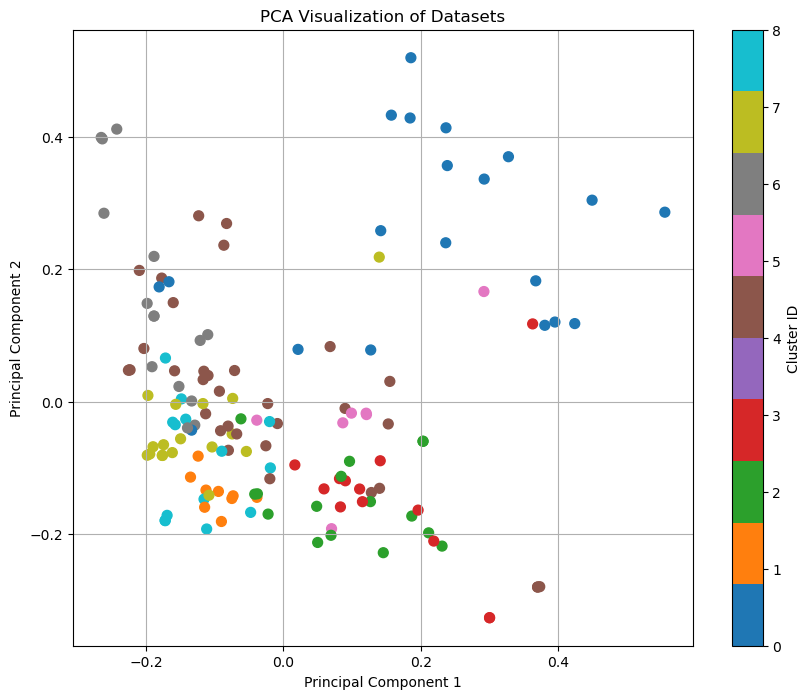

In [19]:
# PCA Visualisation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='tab10', s=50)
plt.colorbar(scatter, label='Cluster ID')
plt.title('PCA Visualization of Datasets')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [20]:
# UMAP reduction
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X)

C:\Users\Marci\anaconda3\envs\NLPtasks2\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Marci\anaconda3\envs\NLPtasks2\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


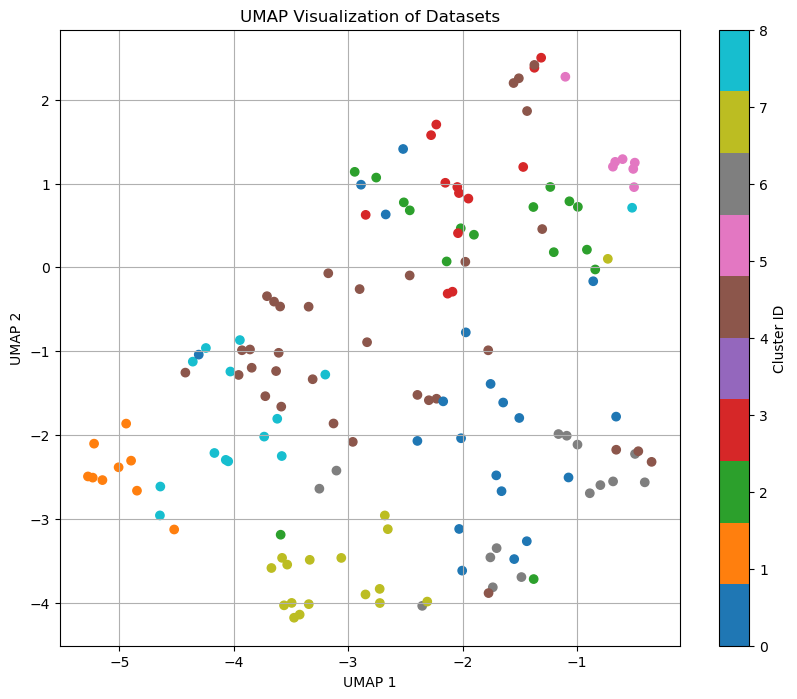

In [21]:
#  UMAP visualisation
plt.figure(figsize=(10, 8))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters, cmap='tab10')
plt.colorbar(label="Cluster ID")
plt.title("UMAP Visualization of Datasets")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()


In [23]:
# reducer = umap.UMAP(n_components=2, random_state=42)
# X_umap = reducer.fit_transform(X)
# # Przetestujemy różne liczby klastrów
# for n_clusters in range(5, 16, 1):  # możesz zmieniać zakres np. (2, 15)
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     clusters = kmeans.fit_predict(X)
    
#     score = silhouette_score(X, clusters)
#     print(f"{n_clusters} clusters → Silhouette score: {score:.3f}")
    
#     # Rysowanie wykresu
#     plt.figure(figsize=(8, 6))
#     plt.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters, cmap="tab10", s=30)
#     plt.title(f"UMAP Visualization - {n_clusters} Clusters\nSilhouette score: {score:.3f}")
#     plt.xlabel("UMAP 1")
#     plt.ylabel("UMAP 2")
#     plt.colorbar(label="Cluster ID")
#     plt.grid(True)
#     plt.show()